### Author: Samuel Hickey

In collaboration with Dallas Hutchinson

## Problem 1:

### Approximate the following function:
$\Large f ( x ) = 3x^2 + 4x - 9 $


### Steps:
1. Randomly generate the data. Generate at least 10,000 values for $x \in [-100,100]$
2. Plot the function
3. Design a feed-forward network with 2 or more hidden layers. Choose the # of hidden units in each layer (what are the size of input and output layers?)
4. Train the model (What loss function will be suitable here?)
5. Generate a test data and present the test accuracy

## Problem 2:

### Feedforward Network
- Hidden layer 1
- Input size 784 [28X28] image
- Hidden layer units 500
- Output size 10
- Other Hyperparameters:
 - num_epochs = 5
 - batch_size = 100
 - learning_rate = 0.001

### Try out different regularization and optimization techniques and vary the corresponding hyperparameters
- Hidden layers/units per layer
- L2 regularization
- Dropout
- RMSProp
- Adam
- Minibatches

### Tabulate your findings

In [1]:
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

c:\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
c:\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Problem 1

In [2]:
def f(x) -> float:
    return 3*x*x + 4*x - 9

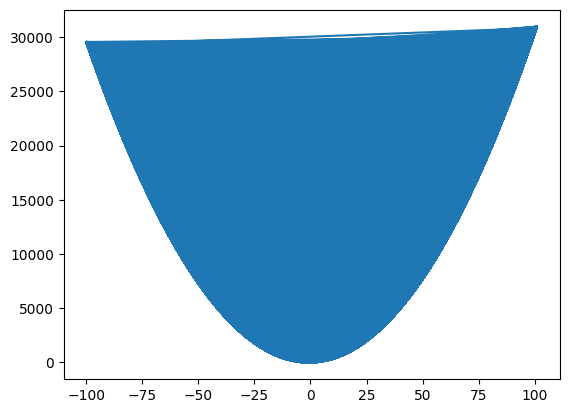

In [3]:
train_x = torch.FloatTensor(50000).uniform_(-100, 101)
train_y = torch.FloatTensor([f(x) for x in train_x])
train_dataloader = DataLoader(
    TensorDataset(train_x.unsqueeze(1), train_y.unsqueeze(1)),
    batch_size=100,
    pin_memory=True,
    shuffle=True
)

valid_x = torch.FloatTensor(5000).uniform_(-100, 101)
valid_y = torch.FloatTensor([f(x) for x in valid_x])
valid_dataloader = DataLoader(
    TensorDataset(valid_x.unsqueeze(1), valid_y.unsqueeze(1)),
    batch_size=100,
    pin_memory=True,
    shuffle=True
)

test_x = torch.FloatTensor(5000).uniform_(-100, 101)
test_y = torch.FloatTensor([f(x) for x in test_x])
test_dataloader = DataLoader(
    TensorDataset(test_x.unsqueeze(1), test_y.unsqueeze(1)),
    batch_size=100,
    pin_memory=True,
    shuffle=True
)

plt.plot(train_x, train_y)
plt.show()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.linear_silu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, num_classes)
        )
          
    
    def forward(self, x):
        out = self.linear_silu_stack(x)
        return out

input_size = 1
hidden_size = 16
num_classes = 1
num_epochs = 50
batch_size = 100
learning_rate = 0.003
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
print(model)

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Using cpu device
NeuralNetwork(
  (linear_silu_stack): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): SiLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): SiLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [14]:
def train():
    losses = []
    for epoch in range(num_epochs):
        model.train()
        tmp_loss = []
        for X_train, y_train in train_dataloader:
            X_train = X_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.float32).to(device)

            score = model(X_train)
            loss = torch.sqrt(criterion(input=score, target=y_train))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss.append(loss.detach().cpu().numpy())
        losses.append([np.average(tmp_loss)])

        model.eval()
        tmp_loss = list()
        for X_val, y_val in valid_dataloader:
            X_val = X_val.type(torch.float32).to(device)
            y_val = y_val.type(torch.float32).to(device)

            score = model(X_val)
            loss = torch.sqrt(criterion(input=score, target=y_val))
            tmp_loss.append(loss.detach().cpu().numpy())
        losses[epoch].append(np.average(tmp_loss))
        # print(f"Epoch {epoch+1}")
        # print(f"Train Loss: {losses[epoch][0]} | Validation Loss: {losses[epoch][1]}")
    losses = np.array(losses)
    return (np.median(losses[:, 0]), np.median(losses[:, 1]))

def test():
    accuracy = []
    for x, y in test_dataloader:
        x = x.type(torch.float32).to(device)
        y = y.type(torch.float32).to(device)

        pred = model(x)
        batch_accuracy = []
        for i in range(batch_size):
            relative_acc = 1 - (abs(pred[i] - y[i]) / y[i])
            batch_accuracy.append(relative_acc.detach().numpy())
        accuracy.append(batch_accuracy)

    return np.average(accuracy)


train_loss = train()
test_acc = test()

print(f"Median Training Difference between Y and Y-hat: {train_loss[0]}")
print(f"Average Test Accuracy: {test_acc}")

Median Training Difference between Y and Y-hat: 61.85984802246094
Average Test Accuracy: 0.9379178881645203


## Problem 2

In [19]:
input_size = 784
hidden_size = 256
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.002

### Defining the Network

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.linear_silu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, num_classes)
        )
          
    
    def forward(self, x):
        out = self.linear_silu_stack(x)
        return out

### Loading the datasets

<i> 
#### Note: If the following code does not work, do the following:
- open a terminal and enter
- pip install ipywidgets
- jupyter nbextension enable --py widgetsnbextension

#### If the second line shows [OK], it should work </i>

In [21]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, shuffle=True)

In [22]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=False, 
                                           transform=transforms.ToTensor(),download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, shuffle=True)

In [23]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [24]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

##### Display samples

3


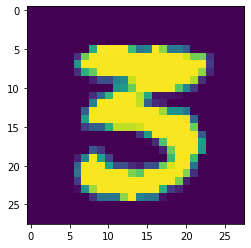

In [29]:
import matplotlib.pyplot as plt
import pandas as pd


for images, labels in train_loader:
    print(labels[0].item())
 
    plt.imshow(images[0].reshape((28,28)))
    pd.DataFrame(np.round(images[0].reshape((28,28)).numpy())) \
        .to_csv('input_sample.csv', sep=',', index=False, header=False)
    break

In [30]:
model = NeuralNetwork(input_size, hidden_size, num_classes)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

### Train the model

In [32]:
total_step = len(train_loader)
model.train()
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Reconfigure the images into a 1D vector (actually, (X,1) tensor)
        images = images.view(images.shape[0], -1)
        # Forward pass
        score = model(images)
        ### Comput the output and loss
        loss = criterion(score, labels)    
        losses.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display the progress
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        

Epoch [1/20], Step [100/600], Loss: 0.5545
Epoch [1/20], Step [200/600], Loss: 0.2315
Epoch [1/20], Step [300/600], Loss: 0.2491
Epoch [1/20], Step [400/600], Loss: 0.1187
Epoch [1/20], Step [500/600], Loss: 0.1410
Epoch [1/20], Step [600/600], Loss: 0.2184
Epoch [2/20], Step [100/600], Loss: 0.1638
Epoch [2/20], Step [200/600], Loss: 0.0597
Epoch [2/20], Step [300/600], Loss: 0.0619
Epoch [2/20], Step [400/600], Loss: 0.1468
Epoch [2/20], Step [500/600], Loss: 0.0762
Epoch [2/20], Step [600/600], Loss: 0.0219
Epoch [3/20], Step [100/600], Loss: 0.0350
Epoch [3/20], Step [200/600], Loss: 0.0882
Epoch [3/20], Step [300/600], Loss: 0.0373
Epoch [3/20], Step [400/600], Loss: 0.1268
Epoch [3/20], Step [500/600], Loss: 0.0492
Epoch [3/20], Step [600/600], Loss: 0.0615
Epoch [4/20], Step [100/600], Loss: 0.0193
Epoch [4/20], Step [200/600], Loss: 0.0497
Epoch [4/20], Step [300/600], Loss: 0.0319
Epoch [4/20], Step [400/600], Loss: 0.0616
Epoch [4/20], Step [500/600], Loss: 0.0108
Epoch [4/20

#### Taking 4 samples from the test set 
- display the image
- print the true label
- print the output probability distribution
- print the predicted class

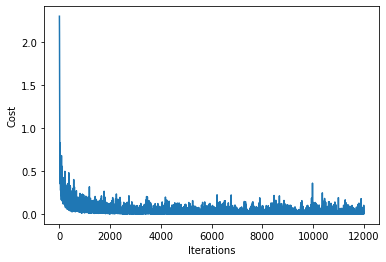

In [33]:
plt.plot(losses)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

In [34]:
def view_class(img, preds, y_hat, y):
    ''' Function for viewing an image and it's predicted classes.
    '''
    preds = preds.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,4), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.bar(np.arange(10), preds)
    ax2.set_aspect(5)
    ax2.set_xticks(np.arange(10))
    ax2.set_xticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1)
    fig.text(.5, .0001, f"Predicted Label: {y_hat} | True Label: {y}", ha='center')

[-18.677568 -26.363962 -31.613543 -15.353566  -6.602241 -17.198635
 -36.352043  -9.925137 -20.857801  32.057606]
[-16.966768  -20.024937  -18.150824  -14.106834  -28.051146  -11.898349
 -28.660831  -23.21542    30.59032    -7.9478607]
[-23.190634  -11.662019   -9.956592  -32.322624   19.309849   -9.080388
 -22.977327  -12.873644  -18.022795    3.2235124]
[-18.775244  -17.00621   -13.101646  -13.578387    0.625664  -13.648289
 -10.830356   -4.7022533  -3.4038157  12.652896 ]


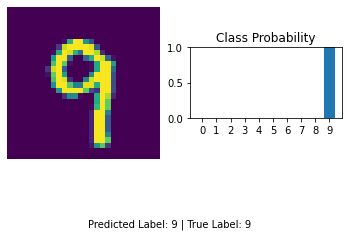

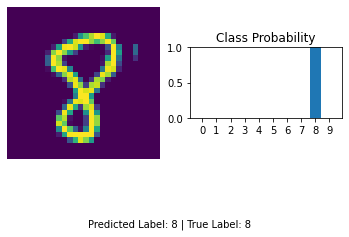

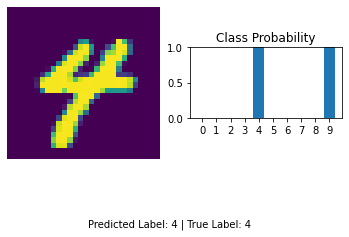

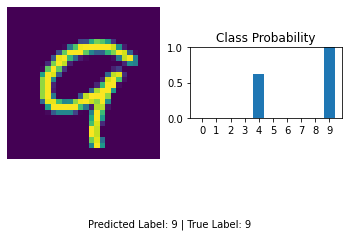

In [35]:
for sample in range(4):
    # Separate images and labels from validation set
    images, labels = next(iter(test_loader))

    # Flatten the 28x28 image
    img = images[sample].view(1, 784)
    
    # Get probability for each class by putting img through the model
    preds = model(img)
    probab = list(preds.detach().numpy()[0])
    y_hat = probab.index(max(probab))
    y = int(labels[sample])
    view_class(img.view(1, 28, 28), preds, y_hat, y)
    print(preds.detach().numpy()[0])

In [36]:
len(dict(model.state_dict()))

6

In [37]:
dict(model.state_dict())

{'linear_silu_stack.0.weight': tensor([[-4.5563e-03, -1.9643e-02,  2.6476e-02,  ..., -1.7378e-02,
           1.0215e-02, -1.6542e-02],
         [-2.2559e-02,  2.0060e-03, -2.8876e-02,  ...,  2.5051e-02,
          -1.1952e-02,  4.4920e-03],
         [-1.8172e-02, -1.1501e-02,  3.0709e-02,  ...,  1.7200e-03,
           9.1601e-03, -1.4239e-03],
         ...,
         [ 3.5040e-02, -2.4057e-02, -7.7646e-03,  ...,  5.9124e-03,
          -1.7618e-02,  4.0617e-05],
         [ 7.5062e-03,  1.7145e-02,  4.3829e-03,  ..., -1.2303e-02,
           1.1883e-02, -3.2564e-02],
         [ 3.4942e-02,  1.2188e-02,  5.5679e-03,  ...,  1.4767e-02,
           2.1347e-02,  8.4994e-03]]),
 'linear_silu_stack.0.bias': tensor([-8.9153e-02, -8.4369e-02, -3.0536e-01, -3.2794e-02, -1.5007e-01,
          2.1009e-01, -2.7003e-02, -7.9466e-02,  1.3194e-01, -1.0556e-01,
          7.2345e-02, -2.0260e-01, -2.8489e-01,  1.7163e-01, -9.9248e-02,
         -2.0510e-01,  9.0201e-02,  3.7130e-02,  1.3682e-01, -8.7371e-02,
